# Creation of test data for the MuseX unit tests

In [1]:
%matplotlib inline
%mpdaf
import glob
import matplotlib.pyplot as plt
import os
from muse_analysis.plotutils import show_images_grid, show_image

Numpy 1.16.2
Astropy 3.2.dev24057
MPDAF 3.2dev


In [2]:
sy = slice(50, 140)
sx = slice(160, 250)
im = Image('/muse/HDFS/public/dataproducts/HDFS-DataProducts-v1.20/IMAGE-HDFS-v1.24.fits')[sy, sx]

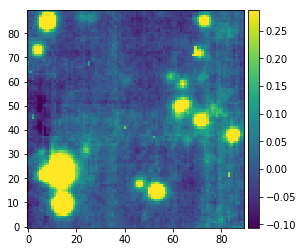

In [3]:
data = im.data.filled(np.nan)
im.plot(zscale=True, colorbar='v');

In [4]:
bkg, bkg_rms = im.background()
threshold = bkg + 2*bkg_rms
threshold

0.0961614800402982

In [5]:
threshold = 0.09

In [6]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources

fwhm = 0.8 / 0.2
sigma = fwhm * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()

In [7]:
segm = detect_sources(im.data, threshold, npixels=5, filter_kernel=kernel)
segm

In [8]:
from photutils import deblend_sources
segm_deblend = deblend_sources(data, segm, npixels=5,
                               filter_kernel=kernel)

/home/conseil/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


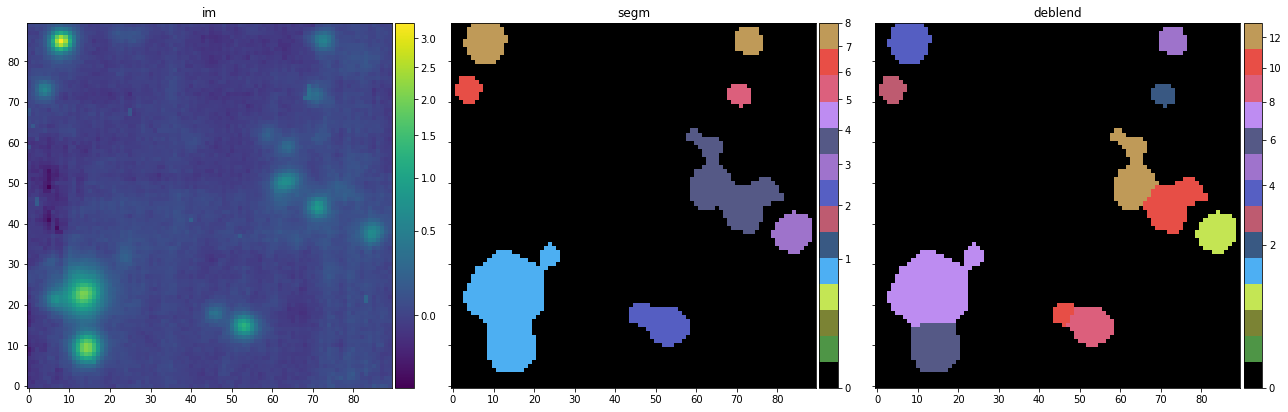

In [9]:
cm = segm_deblend.cmap(random_state=12345)
show_images_grid([im, segm.data, segm_deblend.data], 
                 cmap=['viridis', cm, cm], figsize=(6, 6), 
                 scale='sqrt', titles=['im', 'segm', 'deblend']);

In [10]:
from photutils import source_properties

cat = source_properties(data, segm_deblend, error=im.var, mask=im.mask) #, wcs=im.wcs.wcs)
columns = ['id', 'xcentroid', 'ycentroid', 'source_sum', 'source_sum_err', 'area', 
           'eccentricity', 'orientation', 'ellipticity', 'elongation']
tbl = cat.to_table(columns=columns)
#tbl = cat.to_table()

In [11]:
from astropy.table import Column
coords = np.array([tbl['ycentroid'], tbl['xcentroid']]).T
dec, ra = im.wcs.pix2sky(coords).T
tbl.add_column(Column(name='ra', data=ra), index=1)
tbl.add_column(Column(name='dec', data=dec), index=2)

In [12]:
# for col in tbl.itercols():
#     try:
#         if col.dtype.kind == 'f':
#             col.info.format = '.2f'
#     except:
#         pass
tbl

id,ra,dec,xcentroid,ycentroid,source_sum,source_sum_err,area,eccentricity,orientation,ellipticity,elongation
,,,pix,pix,,,pix2,,rad,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,338.22216683331436,-60.56791899034823,84.17464353709585,37.8735833857062,17.611382994800806,3.8582196214768953,79.0,0.43393342946114793,0.8580410669352785,0.09905506339394576,1.1099457462595834
2,338.223717115442,-60.566030603445334,70.39134668054363,71.85060521460757,5.36989851295948,2.3579307859187533,28.0,0.5278369963327637,-0.3707806312431074,0.1506543075387936,1.1773769018622235
3,338.23122540134506,-60.565947622439595,3.8983534121084236,73.12238343040192,7.717203065752983,2.5785737182307544,37.0,0.37486045077163443,-1.5044325003438939,0.07291875089219557,1.078654110373142
4,338.23075897015997,-60.56529582206629,8.008507386689562,84.87964684116072,47.56456159427762,3.957137899405799,86.0,0.3618120741766021,1.253981251781708,0.06774894852297164,1.0726724291870011
5,338.22344426453924,-60.565293950723195,72.78604306409346,85.1304977128141,9.267546605318785,2.891929673071918,43.0,0.34149582905403886,-0.7723162773518457,0.060116710043904065,1.063961888339043
6,338.23006974404103,-60.56947389750513,14.242037102996946,9.62603692085029,65.34346552938223,4.843022140700766,129.0,0.3788811153062252,-1.56822411586026,0.07455464749975071,1.080560831926303
7,338.2302119381167,-60.5687317201611,12.959857008648024,22.993210706363516,129.69185087271035,7.112266323040305,284.0,0.4017365013359274,0.4063112561507294,0.08424469234714871,1.0919947628401676
8,338.2289866204975,-60.56824280312122,23.794820877858843,31.838575804582526,3.1225252524018288,2.0181706293187514,25.0,0.693823639780682,1.2360735732899375,0.2798550445351391,1.38860932429151


## Save

In [13]:
ls

catalog.fits                     expcube.fits                 origin/
cube.fits                        expima.fits                  segmap.fits
cube-v1.fits                     HDFS-create-test-data.ipynb  settings.yaml
donnees_test_origin_musex.ipynb  image.fits


In [14]:
#cp cube.fits cube-v1.fits

In [15]:
fits.writeto('segmap.fits', segm_deblend.data, header=im.get_wcs_header(), overwrite=True)

In [16]:
tbl.write('catalog.fits', overwrite=True)

In [17]:
im.write('image.fits', savemask='nan')

In [13]:
cube = Cube('/muse/HDFS/public/dataproducts/HDFS-DataProducts-v1.20/DATACUBE-HDFS-v1.24.fits')[:200, sy, sx]
cube.primary_header['FSFMODE'] = 'MOFFAT1 '                                                            
cube.primary_header['FSF00BET']=                  2.8                                                  
cube.primary_header['FSF00FWA']=   0.8693143513610724                                                  
cube.primary_header['FSF00FWB']= -3.4011610870112E-05                                                  
cube.primary_header['NFIELDS'] =                    1
cube.write('cube.fits', savemask='nan')

In [23]:
expcube = Cube('/muse/HDFS/public/dataproducts/HDFS-DataProducts-v1.20/EXPMAP-HDFS-v1.24.fits')[:200, sy, sx]
expcube._data = expcube._data.astype(np.uint8)
expcube.write('expcube.fits', savemask='nan')

In [24]:
expim = Image('/muse/HDFS/public/dataproducts/HDFS-DataProducts-v1.20/EXPMAP-IMAGE-HDFS-v1.24.fits')[sy, sx]
expim._data = expim._data.astype(np.uint8)
expim.write('expima.fits', savemask='nan')

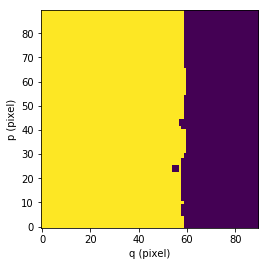

In [25]:
expim.plot()

In [15]:
!ls -lh

total 28M
-rw-rw-r-- 1 conseil udf  12K Dec 18 12:00 catalog.fits
-rw-r--r-- 1 conseil udf  13M Jun 14 15:29 cube.fits
-rw-r--r-- 1 conseil udf  13M Jun 14 15:29 cube-v1.fits
-rw-rw-r-- 1 roehlly udf 447K Jun 14 17:43 donnees_test_origin_musex.ipynb
-rw-rw-r-- 1 conseil udf 1.6M Dec 21 09:23 expcube.fits
-rw-rw-r-- 1 conseil udf  15K Dec 21 09:23 expima.fits
-rw-rw-r-- 1 conseil udf 231K Jun 15 12:26 HDFS-create-test-data.ipynb
-rw-rw-r-- 1 conseil udf  76K Dec 18 12:00 image.fits
drwxr-sr-x 4 conseil udf 4.0K Jun 15 11:29 origin
-rw-rw-r-- 1 conseil udf  68K Dec 18 12:00 segmap.fits
-rw-rw-r-- 1 conseil udf  708 Jan 12 11:00 settings.yaml


In [16]:
!fitsinfo cube.fits

Filename: cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  DATA          1 ImageHDU        74   (90, 90, 200)   float32   
  2  STAT          1 ImageHDU        74   (90, 90, 200)   float32   


## Origin

In [2]:
import numpy as np
import origin

In [3]:
orig = origin.ORIGIN.init('cube.fits', 'segmap.fits', )

INFO : Step 00 - Initialization (ORIGIN v3.2.dev128+g554d26a)
INFO : Read the Data Cube cube.fits
INFO : Compute FSFs from the datacube FITS header keywords
INFO : mean FWHM of the FSFs = 3.27 pixels
INFO : 00 Done


In [4]:
orig.step01_preprocessing()

INFO : Step 01 - Preprocessing
DEBUG:    - dct_order = '' (default: 10)
DEBUG:    - dct_approx = '' (default: False)
DEBUG:    - pfasegcont = '' (default: 0.01)
DEBUG:    - pfasegres = '' (default: 0.01)
DEBUG:    - local_max_size = '' (default: 3)
INFO : DCT computation



DEBUG: dct_residual executed in 2.9s
INFO : Data standardizing
INFO : Std signal saved in self.cube_std and self.ima_std
INFO : Compute local maximum of std cube values
INFO : Save self.cube_local_max/self.cube_local_min from max/min correlations
INFO : DCT continuum saved in self.cont_dct and self.ima_dct
INFO : Segmentation based on the continuum
DEBUG: 1st estimation mean/std/threshold: 1.306431/0.259813/1.910847
INFO : Found 11 regions, threshold=1.75
INFO : Segmentation based on the residual
DEBUG: 1st estimation mean/std/threshold: 0.957779/0.103385/1.198288
INFO : Found 2 regions, threshold=1.18
INFO : Merging both maps
INFO : Segmap saved in self.segmap_merged (11 regions)
INFO : 01 Done - 3.27 sec.


In [5]:
orig.step02_areas()

INFO : Step 02 - Areas creation
DEBUG:    - pfa = '' (default: 0.2) - pfa of the test
DEBUG:    - minsize = '' (default: 100) - min area size
DEBUG:    - maxsize = '' (default: None) - max area size
INFO : Save the map of areas in self.areamap
INFO : 1 areas generated
INFO : 02 Done - 0.02 sec.


In [6]:
orig.step03_compute_PCA_threshold(pfa_test=0.01)

INFO : Step 03 - PCA threshold computation
DEBUG:    - pfa_test = 0.01 (default: 0.01) - pfa of the test
DEBUG: 1st estimation mean/std/threshold: 0.957779/0.103385/1.198288
INFO : Area 1, estimation mean/std/threshold: 0.954079/0.097936/1.181912
INFO : 03 Done - 0.02 sec.


In [7]:
orig.thresO2

(1.1819123595344232,)

In [8]:
orig.step04_compute_greedy_PCA()

INFO : Step 04 - Greedy PCA computation
DEBUG:    - Noise_population = '' (default: 50)
DEBUG:    - itermax = '' (default: 100) - Max number of iterations
DEBUG:    - threshold_list = '' (default: None)
INFO :    - List of threshold = 1.18
INFO : Compute greedy PCA on each zone



DEBUG: Compute_GreedyPCA_area executed in 0.3s
INFO : Save the faint signal in self.cube_faint
INFO : Save the numbers of iterations used by the testO2 for each spaxel in self.mapO2
INFO : 04 Done - 0.30 sec.


In [9]:
orig.step05_compute_TGLR()

INFO : Step 05 - GLR test
DEBUG:    - size = '' (default: 3)
DEBUG:    - ncpu = '' (default: 1)
DEBUG:    - pcut = '' (default: 1e-08)
DEBUG:    - pmeansub = '' (default: True)
INFO : Correlation
INFO : Load dictionary of spectral profile /home/simon/dev/origin/origin/Dico_FWHM_2_12.fits
INFO : Step 1/3 and 2/3: Spatial convolution of weighted data with the zero-mean FSF, Computing Spatial part of the norm of the 3D atoms



INFO : Step 3/3 Computing second cube of correlation values



DEBUG: Correlation_GLR_test executed in 5.5s
INFO : Save the TGLR value in self.cube_correl
INFO : Save the number of profile associated to the TGLR in self.cube_profile
INFO : Save the map of maxima in self.maxmap
INFO : Compute p-values of local maximum of correlation values
INFO : Save self.cube_local_max from max correlations
INFO : Save self.cube_local_min from min correlations
INFO : 05 Done - 5.71 sec.


In [10]:
orig.step06_compute_purity_threshold(purity=.8, threshlist=np.linspace(4, 7, 10))

INFO : Step 06 - Compute Purity threshold
DEBUG:    - purity = 0.8 (default: 0.9)
DEBUG:    - purity_std = '' (default: None)
DEBUG:    - threshlist = array([4.        , 4.33333333, 4.66666667, 5.        , 5.33333333,
       5.66666667, 6.        , 6.33333333, 6.66666667, 7.        ]) (default: None)
DEBUG:    - pfasegfinal = '' (default: 1e-05)
DEBUG:    - bins = '' (default: 'fd')
DEBUG: 1st estimation mean/std/threshold: 3.796307/0.351152/5.293932
INFO : Estimation of threshold with purity = 0.80
INFO : using only background pixels (89.9%)



DEBUG: purity values:
Tval_r Pval_r Det_m Det_M
------ ------ ----- -----
  4.00  -0.00  1440  1439
  4.33   0.01   896   908
  4.67   0.08   501   544
  5.00   0.12   268   305
  5.33   0.06   142   151
  5.67  -0.08    72    67
  6.00  -0.38    34    25
  6.33  -2.34    16     5
  6.67  -4.56     5     1
  7.00   -inf     2     0
DEBUG: Compute_threshold_purity executed in 0.1s
INFO : Threshold: inf 
INFO : Estimation of threshold std with purity = 0.80


/home/simon/dev/origin/origin/lib_origin.py:1418: RuntimeWarning: divide by zero encountered in true_divide
  est_purity = 1 - n0 / n1



DEBUG: purity values:
Tval_r Pval_r Det_m Det_M
------ ------ ----- -----
  4.00  -0.96   100    51
  4.33  -1.27    34    15
  4.67  -1.75    11     4
  5.00  -0.67     5     3
  5.33   0.00     2     2
  5.67   0.50     1     2
  6.00   1.00     0     2
  6.33   1.00     0     2
  6.67   1.00     0     2
  7.00   1.00     0     2
INFO : Interpolated Threshold 5.87 Detection 2 for Purity 0.80
DEBUG: Compute_threshold_purity executed in 0.1s
INFO : Threshold: 5.87 
INFO : 06 Done - 0.18 sec.


In [11]:
orig.threshold_correl

inf

In [12]:
orig.step07_detection(threshold=6.5, threshold_std=5.5)

INFO : Step 07 - Thresholding and spatio-spectral merging
DEBUG:    - threshold = 6.5 (default: None)
DEBUG:    - threshold_std = 5.5 (default: None)
DEBUG:    - tol_spat = '' (default: 3)
DEBUG:    - tol_spec = '' (default: 5)
DEBUG:    - maxdist_lines = '' (default: 2.5)
DEBUG:    - segmap = '' (default: None)
INFO : Thresholding correl (>6.50)
INFO : 3 detected lines
INFO : Thresholding std (>5.50)
INFO : 2 detected lines
INFO : kept 2 lines from std after filtering
INFO : Using segmap_cont with an additional deblending step
INFO : Spatio-spectral merging...
INFO : Purity estimation
INFO : Save the catalog in self.Cat1 (4 [+0] sources, 5 [+2] lines)
INFO : 07 Done - 0.58 sec.


In [13]:
orig.Cat0

x0,y0,z0,comp,STD,T_GLR,profile
int64,int64,int64,int64,float64,float64,int64
14,66,59,0,nan,6.55,1
72,14,109,0,nan,6.59,2
5,73,122,0,nan,6.86,0
72,83,175,1,15.76,nan,0
73,85,175,1,16.93,nan,0


In [14]:
orig.step08_compute_spectra()

INFO : Step 08 - Lines estimation
DEBUG:    - grid_dxy = '' (default: 0)
DEBUG:    - spectrum_size_fwhm = '' (default: 6)



DEBUG: estimation_line executed in 0.3s
INFO : Save the updated catalog in self.Cat2 (5 lines)
INFO : Save estimated spectrum of each line in self.spectra
INFO : 08 Done - 0.32 sec.


In [15]:
orig.step09_clean_results()

INFO : Step 09 - Results cleaning
DEBUG:    - merge_lines_z_threshold = '' (default: 5)



INFO : Save the unique source catalog in self.Cat3_sources (4 sources)
INFO : Save the cleaned lines in self.Cat3_lines (5 lines)
INFO : 1 lines were merged in nearby lines
INFO : 09 Done - 0.17 sec.


In [16]:
orig.step10_create_masks()

INFO : Step 10 - Mask creation
DEBUG:    - path = '' (default: None)
DEBUG:    - overwrite = '' (default: True)
DEBUG:    - mask_size = '' (default: 25)
DEBUG:    - min_sky_npixels = '' (default: 100)
DEBUG:    - seg_thres_factor = '' (default: 0.5)
DEBUG:    - fwhm_factor = '' (default: 2)
DEBUG:    - plot_problems = '' (default: False)


DEBUG: Making mask of source 1.
DEBUG: Making mask of source 2.
DEBUG: Making mask of source 3.
DEBUG: Making mask of source 4.

INFO : 10 Done - 0.27 sec.


In [17]:
orig.threshold_correl, orig.threshold_std

(6.5, 5.5)

In [18]:
#orig.param['threshold'] = 0

In [19]:
orig.step11_save_sources('0.1')

INFO : Step 11 - Save sources
DEBUG:    - version = '' (default: '')
DEBUG:    - path = '' (default: None)
DEBUG:    - n_jobs = '' (default: 1)
DEBUG:    - author = '' (default: '')
DEBUG:    - nb_fwhm = '' (default: 2)
DEBUG:    - expmap_filename = '' (default: None)
DEBUG:    - overwrite = '' (default: True)
INFO : Writing...
DEBUG: step01_preprocessing - DUMP
DEBUG:    - cube_std [cube]
DEBUG:    - cont_dct [cube]
DEBUG:    - ima_std [image]
DEBUG:    - ima_dct [image]
DEBUG:    - segmap_cont [image]
DEBUG:    - segmap_merged [image]
DEBUG:    - cube_std_local_min [cube]
DEBUG:    - cube_std_local_max [cube]
DEBUG: step02_areas - DUMP
DEBUG:    - areamap [image]
DEBUG: step03_compute_PCA_threshold - DUMP
DEBUG:    - thresO2 [array]
DEBUG:    - meaO2 [array]
DEBUG:    - stdO2 [array]
DEBUG: step04_compute_greedy_PCA - DUMP
DEBUG:    - cube_faint [cube]
DEBUG:    - mapO2 [image]
DEBUG: step05_compute_TGLR - DUMP
DEBUG:    - cube_correl [cube]
DEBUG:    - cube_correl_min [cube]
DEBUG: 


INFO : Create the final catalog...


[INFO] Building catalog from path ./origin/sources


 INFO : 11 Done - 4.97 sec.


In [20]:
orig.write()

INFO : Writing...
DEBUG: step11_save_sources - DUMP
INFO : Current session saved in ./origin
DEBUG: write executed in 0.1s


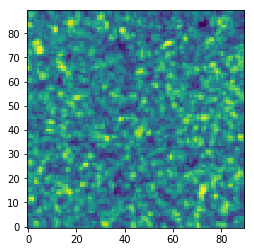

In [21]:
orig.maxmap.plot(zscale=True)

In [22]:
subim = Cube('cube.fits').mean(axis=0)
cat = Catalog.read('origin/Cat3_sources.fits')

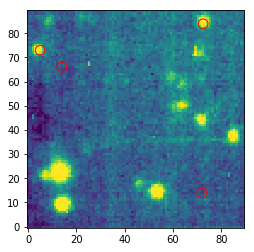

In [23]:
fig, ax = plt.subplots()
subim.plot(ax=ax, zscale=True)
cat.plot_symb(ax, subim.wcs, ra='ra', dec='dec', ecol='r')

In [24]:
cat

ID,ra,dec,x,y,n_lines,seg_label,comp,line_merged_flag,flux,STD,nsigSTD,T_GLR,nsigTGLR,purity
int64,float64,float64,float64,float64,int64,int64,int64,bool,float64,float64,float64,float64,float64,float64
1,338.2300860917844,-60.566344854991016,14.0,66.0,1,0,0,False,26.9,nan,nan,6.55,5.69,0.000
2,338.2235460862445,-60.56924185540205,72.0,14.0,1,0,0,False,24.2,nan,nan,6.59,5.72,0.000
3,338.2311010253501,-60.56595462398222,5.0,73.0,1,7,0,False,134.3,nan,nan,6.86,5.95,0.000
4,338.2234803468103,-60.565360143005094,72.46844457756131,83.9368891551226,1,8,1,True,426.2,16.93,17.21,nan,nan,1.000
